Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 1. Подготовка

In [3]:
import pandas as pd
from tqdm import notebook
import nltk
import re
import numpy as np


df = pd.read_csv('../datasets/toxic_comments.csv')

In [4]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
df.isna().sum(), \
df.duplicated().sum()

(text     0
 toxic    0
 dtype: int64,
 0)

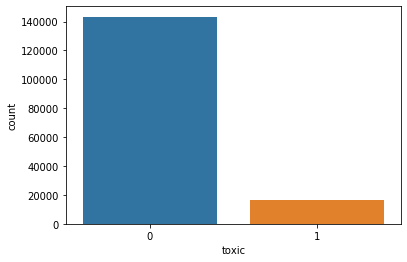

In [7]:
import seaborn as sns

sns.countplot(df['toxic'])

Разделим выборку на train / test.

In [8]:
from sklearn.model_selection import train_test_split

X = pd.DataFrame(data = df['text'], index = df.index)
y = df['toxic']

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = .2, random_state = 42)


In [9]:
X_train.shape ,X_test.shape

((127656, 1), (31915, 1))

# 2. Обучение


### TF-IDF 

Для обучения мы будем использовать sklearn pipelines, в которых будет произведена:
* Лемматизация (c POS тэгами)
* TFIDF векторизация
* Классификация

In [10]:
# Install spaCy (run in terminal/prompt)
import sys
# !{sys.executable} -m pip install spacy
# Download spaCy's  'en' Model
!{sys.executable} -m spacy download en

     |████████████████████████████████| 12.0 MB 952 kB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.5-py3-none-any.whl size=12011738 sha256=ef27fa290f6f3d34013e37ffabede59970ffd80e5e74e4826c2dd8759a6fe8f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-kesoxu2x/wheels/51/19/da/a3885266a3c241aff0ad2eb674ae058fd34a4870fef1c0a5a0
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/home/drresist/anaconda3/lib/python3.7/site-packages/en_core_web_sm -->
/home/drresist/anaconda3/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import spacy
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import re
import nltk


def genericize_mentions(text):
    return re.sub(r'@[\w_-]+', 'thisisanatmention', text)



In [47]:

tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)
count_vect = CountVectorizer(tokenizer=tokenizer.tokenize) 
classifier = LogisticRegression()


from sklearn.preprocessing import FunctionTransformer

def pipelinize(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [function(i) for i in list_or_series]
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

In [26]:
sentiment_pipeline = Pipeline([
        ('genericize_mentions', pipelinize(genericize_mentions)),
        ('vectorizer', count_vect),
        ('classifier', classifier)
    ])

In [27]:
sentiment_pipeline.fit(X_train['text'],y_train)

/home/drresist/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('genericize_mentions',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function pipelinize.<locals>.list_comprehend_a_function at 0x7fcbb87dbb90>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args={'active': True},
                                     validate=False)),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype...
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fcbafdb7050>>,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=

In [28]:
predicts = sentiment_pipeline.predict(X_test['text'])

In [29]:
from sklearn.metrics import f1_score


f1_score(predicts, y_test)

0.7752542372881356

Мы получили требуемое значение. Попробуем классификацию через градиентный бустинг (на примере CatBoost)

In [48]:
from catboost import CatBoostClassifier

In [57]:
ct = CatBoostClassifier?

In [ ]:
ct = CatBoostClassifier

In [62]:
ct = CatBoostClassifier(silent = True)

In [63]:
sentiment_pipeline_ct = Pipeline([
        ('genericize_mentions', pipelinize(genericize_mentions)),
        ('vectorizer', count_vect),
        ('classifier', ct)
    ])

In [64]:
sentiment_pipeline_ct.fit(X_train['text'],y_train)

Pipeline(memory=None,
         steps=[('genericize_mentions',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function pipelinize.<locals>.list_comprehend_a_function at 0x7fcad020fb90>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args={'active': True},
                                     validate=False)),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype...
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
      

In [65]:
predicts = sentiment_pipeline_ct.predict(X_test['text'])
f1_score(predicts, y_test)

0.7565106537971226

Мы получили меньшее значение. Логистическая регрессия показала подходящее качество и более быструю работу. 